# DIGIT CLASSIFICATION USING MACHINE LEARNING-TamilData

Author - Abhishek Kulkarni
         Shejal Pujari
         Sujeet Kumar
         Pragya Manghnani
         Sakshi patil

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel

In [2]:
def croppedImage(img):
    # Import required packages

    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

    # Applying dilation on the threshold image
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    im2 = img.copy()

    countours_largest = sorted(contours, key=lambda x: cv2.contourArea(x))[-1]
    bb=cv2.boundingRect(countours_largest)

    # pt1 and pt2 are terminal coordinates of the diagonal of the rectangle
    pt1=(bb[0],bb[1]) # upper coordinates 
    pt2=(bb[0]+bb[2],bb[1]+bb[3]) # lower coordinates
    cropped = im2[bb[1]:bb[1]+bb[3], bb[0]:bb[0]+bb[2]]
    
    
    img_gray_bb=img.copy()
    
    return cropped

In [3]:
image = []
binary_image = []
label = []
for dir in os.listdir(r"C:\Users\ADMIN\Documents\Msc\Sem3\dataset\tam"):
    path = os.path.join(r"C:\Users\ADMIN\Documents\Msc\Sem3\dataset\tam",dir)
    for data in os.listdir(path):
        img = cv2.imread(os.path.join(path,data))
        img = croppedImage(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(28,28),interpolation = cv2.INTER_AREA)
        # Performing OTSU threshold
        ret, thresh1 = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        # Specify structure shape and kernel size.
        # Kernel size increases or decreases the area
        # of the rectangle to be detected.
        # A smaller value like (10, 10) will detect
        # each word instead of a sentence.
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        # Applying dilation on the threshold image
        dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
        dilation = cv2.erode(dilation, rect_kernel, iterations = 1)
        
#         kernel = np.ones((5, 5), np.uint8)
     
#         # defining the opening function
#         # over the image and structuring element
        image.append(dilation)
        label.append(int(dir))

In [4]:
image = np.array(image, dtype = "float")/255.0

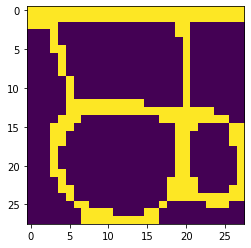

In [5]:
plt.imshow(image[158])

In [6]:
sobel_data = []
for img in image:
    sobel_data.append(sobel(img))

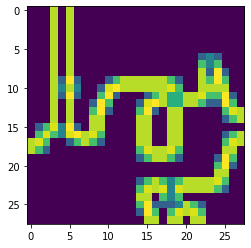

In [7]:
plt.imshow(sobel_data[0])

In [8]:
train_image = np.array(sobel_data, dtype = "float")

In [9]:
from keras.models import Sequential 
from keras.layers import MaxPooling2D , AveragePooling2D,AveragePooling1D
def avgPool(data):
    
    max_pool = MaxPooling2D(pool_size = 2, strides = 1)

    #define a sequential model with just one pooling layer
    model = Sequential([max_pool]) 

    #get the output 
    output = model.predict(data) 

    #print the output  
    output = np.squeeze(output) 
    
    return output


In [10]:
avgData = []
for img in train_image:
    img = img.reshape(1,img.shape[0],-1,1)
    output = avgPool(img)
    avgData.append(output)

1/1 [==============================] - 0s 39ms/step


In [11]:
avgData = np.array(avgData, dtype = "float")

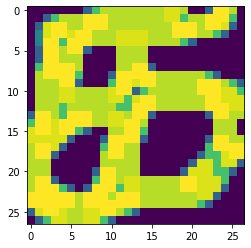

In [12]:
plt.imshow(avgData[120])

In [13]:
from sklearn.model_selection import train_test_split
#Split data into test and train datasets (already split but assigning to meaningful convention)
#If you only have one dataset then split here
x_train, x_test, y_train, y_test = train_test_split(avgData,label,test_size = 0.2, random_state = 11)


In [14]:
train_x = np.reshape(x_train, (x_train.shape[0], -1))
test_x = np.reshape(x_test, (x_test.shape[0], -1))

In [15]:
#Define the classifier
from sklearn.svm import SVC
svc = SVC(probability = True)

#Fit the model on training data 
svc.fit(train_x,y_train)

SVC(probability=True)

In [16]:
#Predict on test
test_prediction = svc.predict(test_x)


#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

#Print confusion matrix
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test, test_prediction))
print(classification_report(y_test, test_prediction))


Accuracy =  0.9226190476190477
[[12  0  0  0  0  0  1  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  1  0  0  0]
 [ 1  0  0 18  0  0  0  0  0  1]
 [ 1  0  0  0 16  0  0  0  0  0]
 [ 0  1  0  0  1 13  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  4]
 [ 0  0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  1  1  0 15]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.95      1.00      0.97        18
           2       1.00      0.93      0.96        14
           3       1.00      0.90      0.95        20
           4       0.94      0.94      0.94        17
           5       1.00      0.87      0.93        15
           6       0.86      0.83      0.84        23
           7       0.94      1.00      0.97        16
           8       1.00      1.00      1.00        15
           9       0.75      0.88      0.81        17

    accuracy                           0.9

In [17]:
def identifyImage(img):
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(28,28),interpolation = cv2.INTER_CUBIC)
    
    
    ret, thresh1 = cv2.threshold(img.copy(), 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # Applying dilation on the threshold image
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    dilation = cv2.erode(dilation,rect_kernel, iterations = 1)
#     plt.imshow(dilation)
#     plt.show()
    input_img_features=sobel(dilation)
    
    input_img_for_RF = input_img_features.reshape(1,input_img_features.shape[0],-1,1)
    input_img_for_RF = avgPool(input_img_for_RF)
    input_img_for_RF = input_img_for_RF.reshape(1,-1)
    img_prediction = svc.predict(input_img_for_RF)
    print(svc.predict_proba(input_img_for_RF))

    print("The prediction for this image is: ", img_prediction)


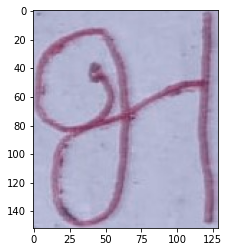

1/1 [==============================] - 0s 44ms/step
[[0.01815659 0.04464473 0.01609888 0.01154075 0.05672636 0.01886484
  0.06347246 0.01709073 0.71440062 0.03900405]]
The prediction for this image is:  [8]


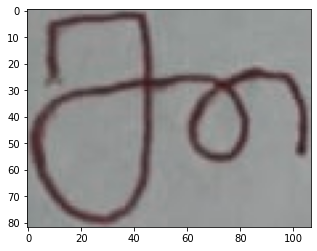

1/1 [==============================] - 0s 41ms/step
[[0.00565    0.00565683 0.00142497 0.00285452 0.02133659 0.00857865
  0.19652452 0.00136403 0.01015755 0.74645234]]
The prediction for this image is:  [9]


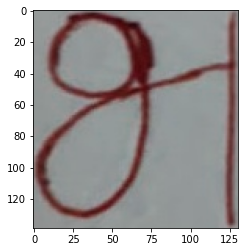

1/1 [==============================] - 0s 52ms/step
[[0.02782753 0.16331127 0.0210742  0.0115224  0.05790268 0.01678894
  0.07679977 0.01399753 0.40941524 0.20136045]]
The prediction for this image is:  [8]


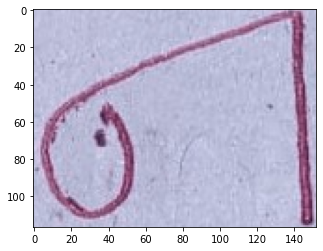

1/1 [==============================] - 0s 39ms/step
[[0.04834828 0.04821343 0.00904599 0.00321242 0.12072402 0.01338245
  0.02115716 0.59263787 0.11303229 0.03024608]]
The prediction for this image is:  [7]


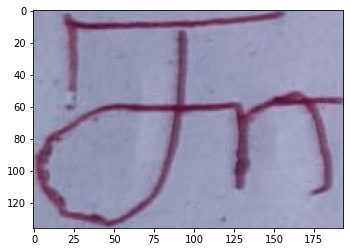

1/1 [==============================] - 0s 47ms/step
[[0.00678037 0.06195831 0.00144528 0.00413583 0.02550709 0.00928857
  0.40045773 0.0022434  0.01248109 0.47570233]]
The prediction for this image is:  [9]


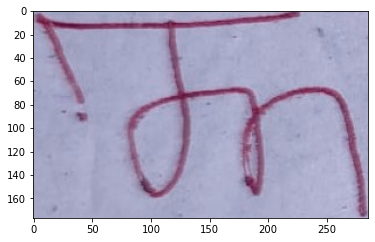

1/1 [==============================] - 0s 39ms/step
[[0.04926876 0.06970306 0.0244899  0.04579436 0.03166492 0.02423164
  0.13966156 0.01253364 0.10666677 0.4959854 ]]
The prediction for this image is:  [9]


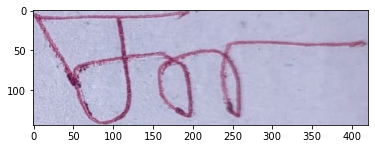

1/1 [==============================] - 0s 41ms/step
[[0.11012755 0.0324946  0.16331069 0.03968465 0.11386925 0.02454427
  0.29419729 0.01700536 0.14370552 0.06106082]]
The prediction for this image is:  [6]


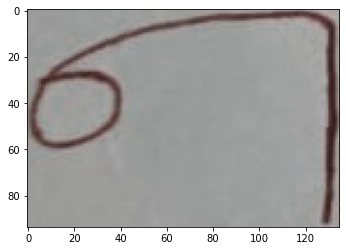

1/1 [==============================] - 0s 39ms/step
[[0.25390586 0.03290436 0.00977966 0.00862003 0.03327971 0.02451081
  0.05655407 0.44671215 0.09721688 0.03651647]]
The prediction for this image is:  [7]


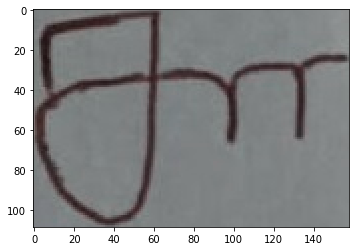

1/1 [==============================] - 0s 48ms/step
[[0.02352651 0.00578121 0.00457806 0.0044129  0.0316692  0.01417806
  0.85175596 0.00613791 0.01621791 0.04174228]]
The prediction for this image is:  [6]


In [18]:
testImg = []
for dir in os.listdir(r"C:\Users\ADMIN\Desktop\tamtest"):
    path = os.path.join(r"C:\Users\ADMIN\Desktop\tamtest",dir)   
        
    img = cv2.imread(path)
    crImage = croppedImage(img)
    plt.imshow(crImage)
    plt.show()
    identifyImage(crImage)
    